## Project 4
**Mohammad Kamal Sadeghabadi Farahani**

### Description
In this project we will create three neural populations, one inhibitory and the other two excitatory and will make connections between them, then we will feed each excitatory population with a noisy current and watch how the activity of populations will change.

### Code
First we will write the code needed for simulation:

In [1]:
import torch
import random
import sys
import numpy as np

sys.path.insert(0, '../../')

from cnsproject.network.neural_populations import ELIFPopulation, LIFPopulation, AELIFPopulation
from cnsproject.network.connections import DenseConnection, RandomConnection
from cnsproject.network.network import Network
from cnsproject.plotting.plotting import raster_plot, plot_activity, plot_current
from cnsproject.network.monitors import Monitor

In [2]:
def simulate_populations(time, params_ex, params_in, connections, current_func_ex1, current_func_ex2):
    lif_ex1 = LIFPopulation(**parameters_ex)
    lif_ex2 = LIFPopulation(**parameters_ex)
    lif_in = LIFPopulation(**parameters_in, is_inhibitory=True)
    dt = lif_in.dt
    steps = int(time / dt)

    network = Network(dt=dt)
    network.add_layer(lif_ex1, 'ex1')
    network.add_layer(lif_ex2, 'ex2')
    network.add_layer(lif_in, 'in')

    synapse_in_to_ex1 = connections['in->ex1']['type'](pre=lif_in, post=lif_ex1, **connections['in->ex1']['params'])
    synapse_in_to_ex2 = connections['in->ex2']['type'](pre=lif_in, post=lif_ex2, **connections['in->ex2']['params'])
    synapse_ex1_to_in = connections['ex1->in']['type'](pre=lif_ex1, post=lif_in, **connections['ex1->in']['params'])
    synapse_ex2_to_in = connections['ex2->in']['type'](pre=lif_ex2, post=lif_in, **connections['ex2->in']['params'])
    synapse_ex1_to_ex1 = connections['ex1->ex1']['type'](pre=lif_ex1, post=lif_ex1, **connections['ex1->ex1']['params'])
    synapse_ex2_to_ex2 = connections['ex2->ex2']['type'](pre=lif_ex2, post=lif_ex2, **connections['ex2->ex2']['params'])

    network.add_connection(synapse_in_to_ex1, 'in', 'ex1')
    network.add_connection(synapse_in_to_ex2, 'in', 'ex2')
    network.add_connection(synapse_ex1_to_in, 'ex1', 'in')
    network.add_connection(synapse_ex2_to_in, 'ex2', 'in')
    network.add_connection(synapse_ex1_to_ex1, 'ex1', 'ex1')
    network.add_connection(synapse_ex2_to_ex2, 'ex2', 'ex2')

    record_time = time
    monitor_ex1 = Monitor(lif_ex1, state_variables=["s", "_potential"])
    monitor_ex1.set_time_steps(record_time, dt)
    monitor_ex1.reset_state_variables()

    monitor_ex2 = Monitor(lif_ex2, state_variables=["s", "_potential"])
    monitor_ex2.set_time_steps(record_time, dt)
    monitor_ex2.reset_state_variables()

    monitor_in = Monitor(lif_in, state_variables=["s", "_potential"])
    monitor_in.set_time_steps(record_time, dt)
    monitor_in.reset_state_variables()

    network.add_monitor(monitor_ex1, 'ex1_monitor')
    network.add_monitor(monitor_ex2, 'ex2_monitor')
    network.add_monitor(monitor_in, 'in_monitor')

    currents = {
        'ex1': [current_func_ex1(i / steps) * torch.ones(lif_ex1.shape) + torch.randn(lif_ex1.shape) * 3 for i in range(steps)],
        'ex2': [current_func_ex2(i / steps) * torch.ones(lif_ex2.shape) + torch.randn(lif_ex1.shape) * 3 for i in range(steps)],
        'in': [torch.zeros(lif_in.shape) for _ in range(steps)]
    }

    network.run(1, currents)
    
    current_ex1 = torch.tensor(list(map(lambda c: c[0], currents['ex1'])))
    current_ex2 = torch.tensor(list(map(lambda c: c[0], currents['ex2'])))
    
    print('Excitatory population 1 raster plot: ')
    raster_plot([monitor_ex1.get('s')], dt)
    print('Input current for Excitatory population 1:')
    plot_current(current_ex1, steps, dt)
    
    print('Excitatory population 2 raster plot: ')
    raster_plot([monitor_ex2.get('s')], dt)
    print('Input current for Excitatory population 2:')
    plot_current(current_ex2, steps, dt)
    
    print('Inhibitory population raster plot: ')
    raster_plot([monitor_in.get('s')], dt)
    
    print('Excitatory population 1 activity: ')
    plot_activity([monitor_ex1.get('s')], dt)
    print('Excitatory population 2 activity: ')
    plot_activity([monitor_ex2.get('s')], dt)
    print('Inhibitory population activity: ')
    plot_activity([monitor_in.get('s')], dt)

### Experiment 1

Excitatory population 1 raster plot: 


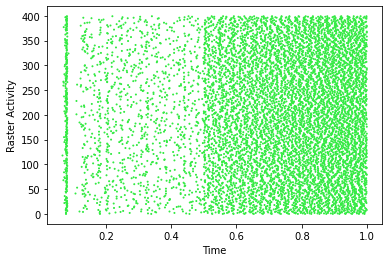

Input current for Excitatory population 1:


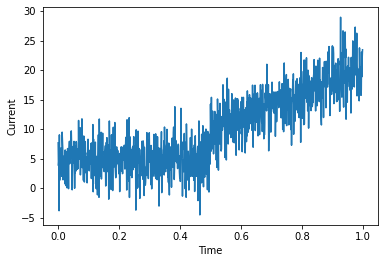

Excitatory population 2 raster plot: 


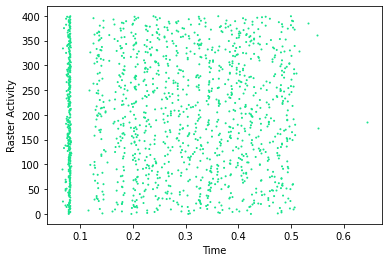

Input current for Excitatory population 2:


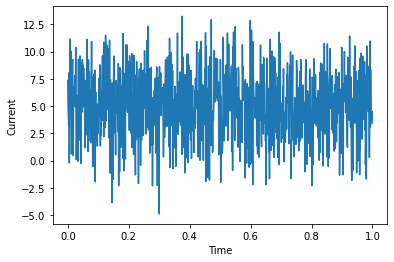

Inhibitory population raster plot: 


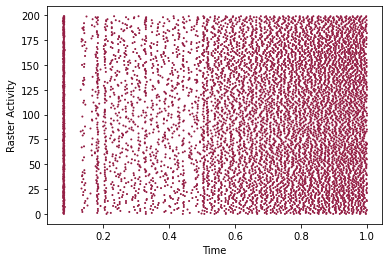

Excitatory population 1 activity: 


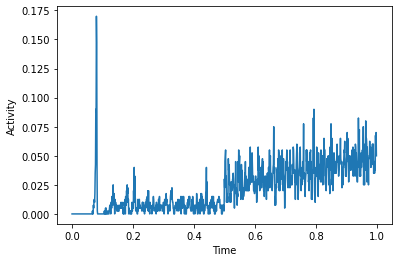

Excitatory population 2 activity: 


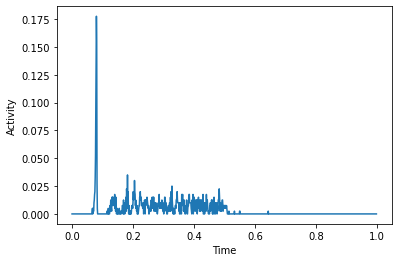

Inhibitory population activity: 


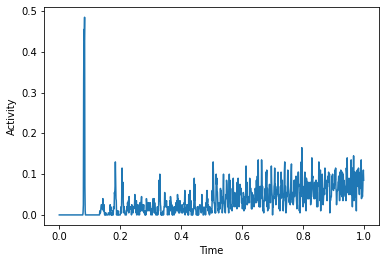

In [3]:
parameters_ex = {
    'tau': 0.1,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -55,
    'shape': (400,)
}

parameters_in = {
    'tau': 0.05,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -65,
    'shape': (200,)
}

connections = {
    'in->ex1': { 'type': RandomConnection, 'params': { 'connection_size': 10 }  },
    'in->ex2': { 'type': RandomConnection, 'params': { 'connection_size': 10 }  },
    'ex1->in': { 'type': RandomConnection, 'params': { 'connection_size': 20 }  },
    'ex2->in': { 'type': RandomConnection, 'params': { 'connection_size': 20 }  },
    'ex1->ex1': { 'type': RandomConnection, 'params': { 'connection_size': 10 }  },
    'ex2->ex2': { 'type': RandomConnection, 'params': { 'connection_size': 10 }  }
}

current_func_ex1 = lambda t: 5 if t < 0.5 else 20 * t
current_func_ex2 = lambda t: 5

simulate_populations(1, parameters_ex, parameters_in, connections, current_func_ex1, current_func_ex2)

### Analysis of experiment 1

| Population | R | $u_{rest}$ | $u_{\theta}$ | $\tau$ | size
| -------  | -------| ------- | ------- | ------- | ------- |
| Excitatory 1 | 5 | -70 | -55 | 0.1 | 400 |
| Excitatory 2 | 5 | -70 | -55 | 0.1 | 400 |
| Inhibitory | 5 | -70 | -65 | 0.05 | 200 |

**Inhibitory $\to$ Excitatory 1**: Random connection with 10 presynaptic connections  
**Inhibitory $\to$ Excitatory 2**: Random connection with 10 presynaptic connections  
**Excitatory 1 $\to$ Inhibitory**: Random connection with 20 presynaptic connections  
**Excitatory 2 $\to$ Inhibitory**: Random connection with 20 presynaptic connections  
**Excitatory 1 $\to$ Excitatory 1**: Random connection with 10 presynaptic connections  
**Excitatory 2 $\to$ Excitatory 2**: Random connection with 10 presynaptic connections  

As we can see after 0.5 second when the input current to excitatory population 1 starts to increase the activity of inhibitory population and excitatory population 1 increases. this will lead to more inhibition from inhibitory population on both excitatory populations, but because the input current of excitatory population 2 hasn't increased after 0.5, the activity of excitatory population 2 will start to decrease as the activity of excitatory population 1 and thus the inhibitory population increase.

### Experiment 2

Excitatory population 1 raster plot: 


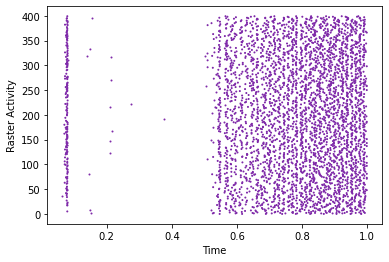

Input current for Excitatory population 1:


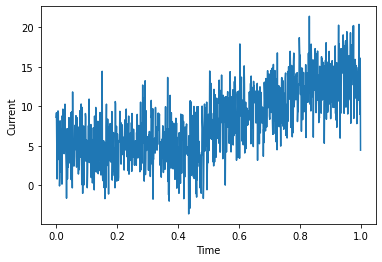

Excitatory population 2 raster plot: 


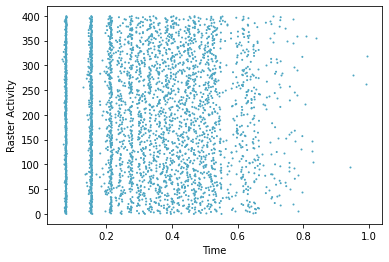

Input current for Excitatory population 2:


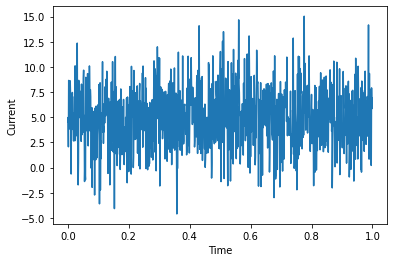

Inhibitory population raster plot: 


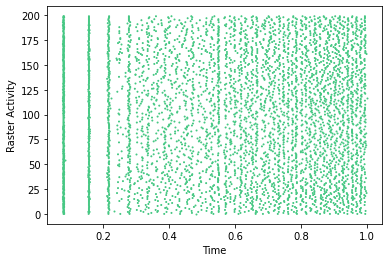

Excitatory population 1 activity: 


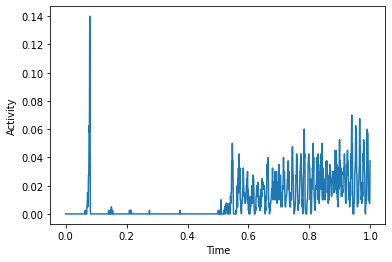

Excitatory population 2 activity: 


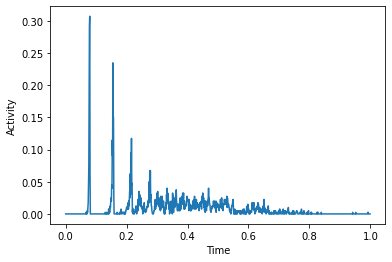

Inhibitory population activity: 


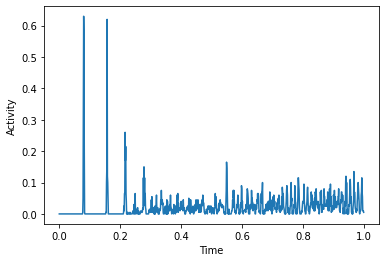

In [9]:
parameters_ex = {
    'tau': 0.1,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -55,
    'shape': (400,)
}

parameters_in = {
    'tau': 0.05,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -65,
    'shape': (200,)
}

connections = {
    'in->ex1': { 'type': RandomConnection, 'params': { 'connection_size': 20 }  },
    'in->ex2': { 'type': RandomConnection, 'params': { 'connection_size': 10 }  },
    'ex1->in': { 'type': RandomConnection, 'params': { 'connection_size': 20 }  },
    'ex2->in': { 'type': RandomConnection, 'params': { 'connection_size': 20 }  },
    'ex1->ex1': { 'type': RandomConnection, 'params': { 'connection_size': 10 }  },
    'ex2->ex2': { 'type': RandomConnection, 'params': { 'connection_size': 20 }  }
}

current_func_ex1 = lambda t: 5 if t < 0.5 else 15 * t
current_func_ex2 = lambda t: 5

simulate_populations(1, parameters_ex, parameters_in, connections, current_func_ex1, current_func_ex2)

### Analysis of experiment 2

| Population | R | $u_{rest}$ | $u_{\theta}$ | $\tau$ | size
| -------  | -------| ------- | ------- | ------- | ------- |
| Excitatory 1 | 5 | -70 | -55 | 0.1 | 400 |
| Excitatory 2 | 5 | -70 | -55 | 0.1 | 400 |
| Inhibitory | 5 | -70 | -65 | 0.05 | 200 |

**Inhibitory $\to$ Excitatory 1**: Random connection with 20 presynaptic connections  
**Inhibitory $\to$ Excitatory 2**: Random connection with 10 presynaptic connections  
**Excitatory 1 $\to$ Inhibitory**: Random connection with 20 presynaptic connections  
**Excitatory 2 $\to$ Inhibitory**: Random connection with 20 presynaptic connections  
**Excitatory 1 $\to$ Excitatory 1**: Random connection with 10 presynaptic connections  
**Excitatory 2 $\to$ Excitatory 2**: Random connection with 20 presynaptic connections  

In this experiment we have stronger connection from inhibitory population to excitatory population 1 compared to excitatory population 2, and a stronger connection from excitatory population 2 to itself. Thus we can see form time 0 to 0.5 as long as the input currents to both populations are almost the same, because we have a stronger connection from inhibitory population to excitatory population 1 and a stronger connection from excitatory population 2 to itself, the activity of excitatory population 1 is lower than excitatory population 2.
but as soon as we start to increase the input current of excitatory population 1 after 0.5 we can see that the activity of excitatory population 2 will start to increase and thus the activity of inhibitory population, this will lead to more inhibition effect from inhibitory population on both excitatory populations but because the input current to the excitatory population 2 is alomost constant, this will lead to decrease in activity of excitatory population 2 after 0.5

### Experiment 3

Excitatory population 1 raster plot: 


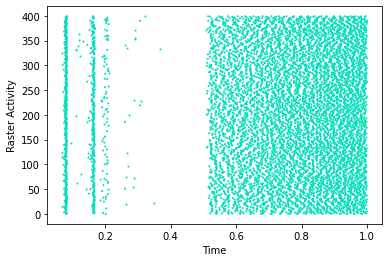

Input current for Excitatory population 1:


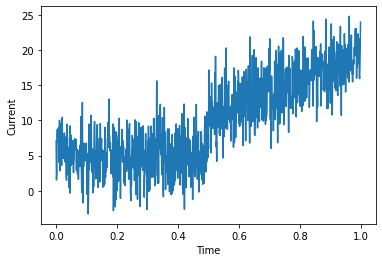

Excitatory population 2 raster plot: 


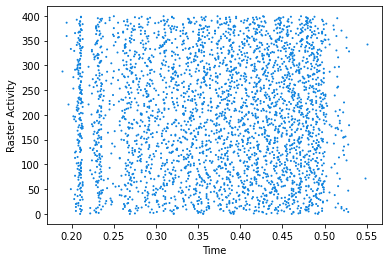

Input current for Excitatory population 2:


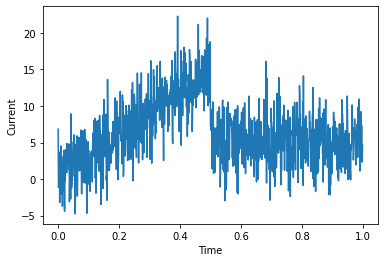

Inhibitory population raster plot: 


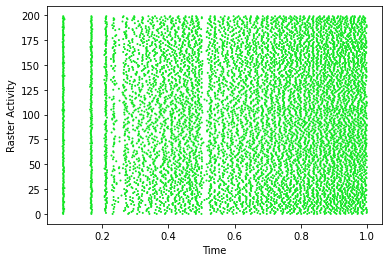

Excitatory population 1 activity: 


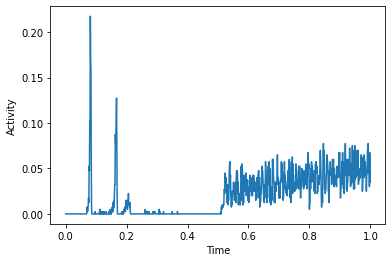

Excitatory population 2 activity: 


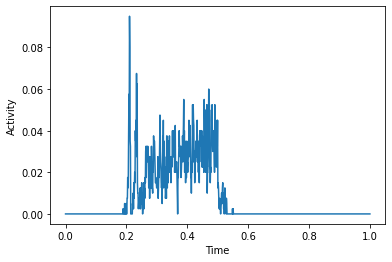

Inhibitory population activity: 


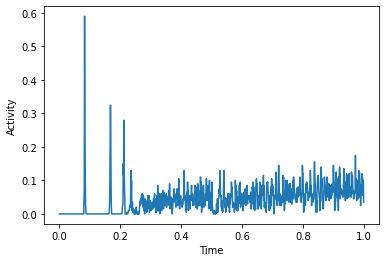

In [11]:
parameters_ex = {
    'tau': 0.1,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -55,
    'shape': (400,)
}

parameters_in = {
    'tau': 0.05,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -65,
    'shape': (200,)
}

connections = {
    'in->ex1': { 'type': RandomConnection, 'params': { 'connection_size': 10 }  },
    'in->ex2': { 'type': RandomConnection, 'params': { 'connection_size': 10 }  },
    'ex1->in': { 'type': RandomConnection, 'params': { 'connection_size': 20 }  },
    'ex2->in': { 'type': RandomConnection, 'params': { 'connection_size': 20 }  },
    'ex1->ex1': { 'type': RandomConnection, 'params': { 'connection_size': 10 }  },
    'ex2->ex2': { 'type': RandomConnection, 'params': { 'connection_size': 10 }  }
}

current_func_ex1 = lambda t: 5 if t < 0.5 else 20 * t
current_func_ex2 = lambda t: 30 * t if t < 0.5 else 5

simulate_populations(1, parameters_ex, parameters_in, connections, current_func_ex1, current_func_ex2)

### Analysis of experiment 3

| Population | R | $u_{rest}$ | $u_{\theta}$ | $\tau$ | size
| -------  | -------| ------- | ------- | ------- | ------- |
| Excitatory 1 | 5 | -70 | -55 | 0.1 | 400 |
| Excitatory 2 | 5 | -70 | -55 | 0.1 | 400 |
| Inhibitory | 5 | -70 | -65 | 0.05 | 200 |

**Inhibitory $\to$ Excitatory 1**: Random connection with 10 presynaptic connections  
**Inhibitory $\to$ Excitatory 2**: Random connection with 10 presynaptic connections  
**Excitatory 1 $\to$ Inhibitory**: Random connection with 20 presynaptic connections  
**Excitatory 2 $\to$ Inhibitory**: Random connection with 20 presynaptic connections  
**Excitatory 1 $\to$ Excitatory 1**: Random connection with 10 presynaptic connections  
**Excitatory 2 $\to$ Excitatory 2**: Random connection with 10 presynaptic connections  

In this experiment we have the same set up as the experiment 1 except the input currents to populations, as we can see from time 0 to 0.5 the input current to excitatory population 1 is almost constant and the input current to excitatory population 2 is increasing, so this will lead to increase in activity of both inhibitory population and excitatory population 2 and decrease in activity of excitatory population 1. But after 0.5 as soon as we increase the input current to excitatory population 1 and change the input current of excitatory population 2 to a almost constant current, we can see that the activity of excitatory population 1 will start to increase and at the same time the activity of excitatory population 2 will start to decrease. 